<h1 align=center style="line-height:200%;font-family:verdana;color:#0099cc">
Warranty Sentiment Analysis
</h1>

### Introduction and Problem Statement

In this notebook, the goal is to **identify and analyze user opinions related to product warranties**  
(such as “warranty,” “guarantee,” “return policy,” etc.) from Amazon product reviews.

The process includes:

1. Computing **text embeddings** for all user reviews using a sentence-transformer model.  
2. Performing **semantic similarity** and **fuzzy matching** to detect warranty-related texts.  
3. Calculating the **average user satisfaction (rating)** for reviews that mention warranty-related topics.  
4. Analyzing the overall sentiment trend and identifying brands or products with the best (or worst) warranty perception.

The dataset contains three main columns:

- **`fullText`** → The full text of each review (concatenation of review text and summary).  
- **`overall`** → Numeric rating between 1 and 5.  
- **`asin`** → Product ID, used to connect to brand and title metadata.


In [1]:
# Install all required libraries
!pip install -q sentence-transformers transformers faiss-cpu rapidfuzz symspellpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.6/159.6 kB 7.3 MB/s eta 0:00:00


In [2]:
# Import core libraries
import os
import time
import numpy as np
import pandas as pd
from collections import Counter
import re
from tqdm.auto import tqdm

# PyTorch and embeddings
import torch
from sentence_transformers import SentenceTransformer, util

# Fuzzy string matching
from rapidfuzz import process, fuzz

# Spelling correction
from symspellpy.symspellpy import SymSpell, Verbosity

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Mount Google Drive to access the dataset files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define dataset paths
TRAIN_PATH = '/content/drive/My Drive/project2/cleaned_balanced_data.csv'
BRAND_PATH = '/content/drive/My Drive/project2/title_brand.csv'

# Load data
train_df = pd.read_csv(TRAIN_PATH)
brand_df = pd.read_csv(BRAND_PATH)

# Preview dataset
train_df.head()

,asin,fullText,overall
0,B00B5Q7ACE,"slow drive, multiple timeouts . this is a real...",1
1,B00INF5IU6,left side fails after several months of gentle...,1
2,B015PD3HOC,"netgear ac5300 x8 not worth it! . hello, i pur...",1
3,B00G9XGAPG,"after three days one alive, one dead,and one o...",1
4,B01AWGYE12,"lovely projector, but basically useless becaus...",1


### Model and Embedding Computation

We use the **`all-mpnet-base-v2`** sentence transformer to generate semantic embeddings for all reviews.  
Embeddings capture the contextual meaning of each review, allowing semantic similarity search later.


In [5]:
MODEL_NAME = 'all-mpnet-base-v2'
BATCH_SIZE = 128
EMBEDDINGS_CACHE = '/content/review_embeddings.npy'
TOKEN_EMBEDDINGS_CACHE = '/content/token_embeddings.npy'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Device: {DEVICE}")
print(f"Using model: {MODEL_NAME}")

Device: cuda
Using model: all-mpnet-base-v2


In [6]:
# Initialize model
model = SentenceTransformer(MODEL_NAME, device=DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
print(f"Number of reviews: {len(train_df):,}")

Number of reviews: 386,845


In [8]:
# Function to compute or load embeddings from cache
def compute_or_load_review_embeddings(reviews, cache_path=EMBEDDINGS_CACHE, batch_size=BATCH_SIZE):
    if os.path.exists(cache_path):
        try:
            arr = np.load(cache_path, allow_pickle=False)
            print(f"Loaded cached review embeddings from {cache_path}. Shape: {arr.shape}")
            return arr
        except Exception as e:
            print("Failed to load cache, will recompute. Error:", e)

    print("Computing review embeddings ...")
    start = time.time()
    embeddings = model.encode(reviews, batch_size=batch_size, show_progress_bar=True, convert_to_numpy=True)
    np.save(cache_path, embeddings)
    print(f"Saved embeddings to {cache_path}. Time: {time.time() - start:.1f}s. Shape: {embeddings.shape}")
    return embeddings

# Generate or load review embeddings
reviews_list = train_df['fullText'].tolist()
review_embeddings = compute_or_load_review_embeddings(reviews_list)


Computing review embeddings (this may take time)...


Batches:   0%|          | 0/3023 [00:00<?, ?it/s]

Saved embeddings to /content/review_embeddings.npy. Time: 3782.1s. Shape: (386845, 768)


### Token Vocabulary Construction and Embedding

To identify warranty-related terms, we first build a vocabulary of the most frequent tokens in reviews.  
Then, we compute embeddings for these tokens to measure their similarity with “warranty”-related seed words.


In [9]:
# Tokenization helper
def simple_tokenize(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

In [10]:
# Build vocabulary of top tokens
TOP_TOKEN_COUNT = 5000
print("Building token vocabulary (frequent tokens)...")
counter = Counter()
for txt in tqdm(train_df['fullText'].astype(str).values, desc='tokenizing'):
    counter.update(simple_tokenize(txt))

most_common_tokens = [t for t, _ in counter.most_common(TOP_TOKEN_COUNT)]
print(f"Collected top {len(most_common_tokens)} tokens.")


Building token vocabulary (frequent tokens)...


tokenizing:   0%|          | 0/386845 [00:00<?, ?it/s]

Collected top 5000 tokens.


In [11]:
# Compute embeddings for tokens
def compute_or_load_token_embeddings(tokens, cache_path=TOKEN_EMBEDDINGS_CACHE, batch_size=256):
    if os.path.exists(cache_path):
        try:
            data = np.load(cache_path, allow_pickle=True).item()
            print(f"Loaded cached token embeddings from {cache_path}.")
            return data['tokens'], data['embeddings']
        except Exception as e:
            print("Failed to load token cache, will recompute. Error:", e)

    print("Computing token embeddings...")
    token_embeddings = model.encode(tokens, batch_size=batch_size, show_progress_bar=True, convert_to_numpy=True)
    np.save(cache_path, {'tokens': np.array(tokens), 'embeddings': token_embeddings})
    print("Saved token embeddings.")
    return tokens, token_embeddings

tokens, token_embeddings = compute_or_load_token_embeddings(most_common_tokens)


Computing token embeddings...


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Saved token embeddings.


### Finding Similar and Fuzzy Words

We identify words related to “warranty” and “guarantee” by:
1. **Semantic similarity** – finding tokens close in meaning.  
2. **Fuzzy matching** – expanding to include misspellings and variations.


In [12]:
seed_words = ['warranty', 'guarantee']

# Find semantically similar tokens
def find_similar_tokens(seed_words, tokens, token_embeddings, top_k=30, similarity_cutoff=0.55):
    seed_embs = model.encode(seed_words, convert_to_numpy=True)
    results = {}
    for sw, emb in zip(seed_words, seed_embs):
        sims = util.cos_sim(emb, token_embeddings)[0]
        top_idx = np.argsort(-sims)[:top_k]
        similar = []
        for idx in top_idx:
            score = float(sims[idx])
            tok = tokens[idx]
            if score >= similarity_cutoff:
                similar.append((tok, score))
        results[sw] = similar
    return results

In [13]:
print("Finding similar tokens to seed words (embedding-based)...")
similar_tokens = find_similar_tokens(seed_words, tokens, token_embeddings, top_k=200, similarity_cutoff=0.52)
for k, vals in similar_tokens.items():
    print(f"\nTop similar tokens for '{k}':")
    print([f"{tok}:{score:.3f}" for tok, score in vals][:20])


Finding similar tokens to seed words (embedding-based)...

Top similar tokens for 'warranty':
['warranty:1.000', 'guarantee:0.523']

Top similar tokens for 'guarantee':
['guarantee:1.000', 'promise:0.581', 'promised:0.576', 'warranty:0.523']


In [14]:
# Fuzzy expansion for typos
def fuzzy_candidates(word, token_vocab, limit=30, score_cutoff=70):
    results = process.extract(word, token_vocab, scorer=fuzz.ratio, limit=limit)
    results = [(tok, score) for tok, score, _ in results if score >= score_cutoff]
    return results

In [15]:
keywords = set()
for sw, lst in similar_tokens.items():
    for tok, score in lst:
        keywords.add(tok)

In [16]:
keywords.update(seed_words)

In [17]:
# Add fuzzy matches
FINAL_FUZZY_LIMIT = 30
FUZZY_SCORE_CUTOFF = 75
token_vocab = list(tokens)
print("\nExpanding keywords with fuzzy matches (to catch typos)...")
for kw in list(keywords):
    fz = fuzzy_candidates(kw, token_vocab, limit=FINAL_FUZZY_LIMIT, score_cutoff=FUZZY_SCORE_CUTOFF)
    for tok, score in fz:
        keywords.add(tok)



Expanding keywords with fuzzy matches (to catch typos)...


In [18]:
keywords = sorted(list(keywords))
print(f"Total keywords collected for warranty search: {len(keywords)}")
print(keywords)

Total keywords collected for warranty search: 8
['array', 'compromise', 'granted', 'guarantee', 'promise', 'promised', 'provided', 'warranty']


### Semantic Search and Masking

We now use the semantic embeddings to locate reviews that are semantically similar to  
phrases related to warranty, guarantee, returns, or repair.


In [19]:
query_phrases = [
    'warranty',
    'guarantee',
    'product warranty and guarantee',
    'return policy',
    'refund',
    'defective on arrival',
    'dead on arrival',
    'replacement',
    'repair service',
    'customer service about warranty'
]
query_embeddings = model.encode(query_phrases, convert_to_numpy=True)

In [20]:
SEMANTIC_TOP_K = 5
SEMANTIC_SCORE_THRESHOLD = 0.45

print("Running semantic_search (this tries to use FAISS if available)...")
hits = util.semantic_search(query_embeddings, review_embeddings, top_k=SEMANTIC_TOP_K)


Running semantic_search (this tries to use FAISS if available)...


In [21]:
# Build semantic mask
semantic_mask = np.zeros(len(reviews_list), dtype=bool)
for q_idx, q_hits in enumerate(hits):
    for h in q_hits:
        if h['score'] >= SEMANTIC_SCORE_THRESHOLD:
            semantic_mask[h['corpus_id']] = True

print(f"Semantic mask found {semantic_mask.sum():,} candidate reviews (score >= {SEMANTIC_SCORE_THRESHOLD}).")

Semantic mask found 46 candidate reviews (score >= 0.45).


In [22]:
# Keyword mask using fuzzy substring checks
def review_contains_keyword(review, keywords, fuzzy_threshold=90):
    txt = str(review).lower()
    for kw in keywords:
        if f' {kw} ' in f' {txt} ' or txt.startswith(kw + ' ') or txt.endswith(' ' + kw) or txt == kw:
            return True
    for kw in keywords:
        if len(kw) <= 12:
            score = fuzz.partial_ratio(kw, txt)
            if score >= fuzzy_threshold:
                return True
    return False

In [23]:
print("Building keyword mask (exact + fuzzy substring checks). This may take a moment...")
keyword_mask = np.zeros(len(reviews_list), dtype=bool)
for i, txt in enumerate(tqdm(reviews_list, desc='keyword-check')):
    if review_contains_keyword(txt, keywords, fuzzy_threshold=88):
        keyword_mask[i] = True

print(f"Keyword mask found {keyword_mask.sum():,} candidate reviews.")

Building keyword mask (exact + fuzzy substring checks). This may take a moment...


keyword-check:   0%|          | 0/386845 [00:00<?, ?it/s]

Keyword mask found 20,636 candidate reviews.


In [24]:
combined_mask = semantic_mask | keyword_mask
print(f"Combined selection: {combined_mask.sum():,} reviews selected as warranty-related.")

Combined selection: 20,666 reviews selected as warranty-related.


In [25]:
train_df['is_warranty_candidate'] = combined_mask
train_df['warranty_semantic_score'] = 0.0

### Calculating Average Warranty Sentiment

We calculate the **average rating (sentiment)** for all warranty-related reviews,  
and report the top and bottom products based on user satisfaction.


In [26]:
# Compute maximum semantic similarity per review
max_scores = np.zeros(len(reviews_list))
for q_hits in hits:
    for h in q_hits:
        cid = h['corpus_id']
        sc = h['score']
        if sc > max_scores[cid]:
            max_scores[cid] = sc
train_df['warranty_semantic_score'] = max_scores

In [27]:
# Define automatic threshold
AUTO_QUANTILE = 0.90
quantile_val = np.quantile(train_df['warranty_semantic_score'], AUTO_QUANTILE)
SEMANTIC_AUTO_THRESHOLD = quantile_val
print(f"Auto semantic threshold at quantile {AUTO_QUANTILE}: {SEMANTIC_AUTO_THRESHOLD:.4f}")

Auto semantic threshold at quantile 0.9: 0.0000


In [28]:
final_mask = (train_df['is_warranty_candidate']) | (train_df['warranty_semantic_score'] >= SEMANTIC_AUTO_THRESHOLD)
print(f"Final mask selects {final_mask.sum():,} reviews after auto-thresholding.")

train_df['is_warranty_final'] = final_mask

Final mask selects 386,845 reviews after auto-thresholding.


In [29]:
warranty_reviews_df = train_df[train_df['is_warranty_final']].copy()
print(f"Warranty-related reviews: {len(warranty_reviews_df):,}")

# Group sentiment by product
if not warranty_reviews_df.empty:
    warranty_sentiment_by_product = (
        warranty_reviews_df.groupby('asin')['overall']
        .agg(['mean', 'count'])
        .reset_index()
        .rename(columns={'mean': 'avg_warranty_sentiment', 'count': 'warranty_review_count'})
    )
    top10 = warranty_sentiment_by_product[warranty_sentiment_by_product['warranty_review_count'] > 1].sort_values(by='avg_warranty_sentiment', ascending=False).head(10)
    bottom10 = warranty_sentiment_by_product[warranty_sentiment_by_product['warranty_review_count'] > 1].sort_values(by='avg_warranty_sentiment', ascending=True).head(10)
    print("Top 10 products by avg warranty sentiment (count>1):")
    display(top10)
    print("Bottom 10 products by avg warranty sentiment (count>1):")
    display(bottom10)
else:
    print("No warranty-related reviews found with current settings. Consider lowering thresholds or expanding keywords.")

Warranty-related reviews: 386,845
Top 10 products by avg warranty sentiment (count>1):


,asin,avg_warranty_sentiment,warranty_review_count
70768,B01HH8H2WQ,5.0,2
33287,B00LJGUZPY,5.0,2
70744,B01HGJLK38,5.0,2
33302,B00LJX5R32,5.0,2
77,B00000JBUI,5.0,2
203,B00004Z5T2,5.0,2
70792,B01HHYQBB8,5.0,2
70813,B01HIA63ZA,5.0,3
37991,B00OZHSKD8,5.0,2
37993,B00OZJ6FJM,5.0,2


Bottom 10 products by avg warranty sentiment (count>1):


,asin,avg_warranty_sentiment,warranty_review_count
5267,B001DEUPIE,1.0,2
66067,B01E5BBFNA,1.0,2
66129,B01E6PGZ0I,1.0,2
4135,B000WXG5PE,1.0,2
4108,B000WKPHHO,1.0,2
4090,B000WDSFPM,1.0,3
66177,B01E7N7ZBC,1.0,2
47094,B00YBCHVU0,1.0,2
5270,B001DF7EC8,1.0,2
36462,B00NQW4H7G,1.0,2


In [30]:
merged = pd.merge(warranty_sentiment_by_product, brand_df, on='asin', how='left')
merged = merged.sort_values(by='avg_warranty_sentiment', ascending=False)
print("Merged with brand/title. Example rows:")
display(merged.head(10))

Merged with brand/title. Example rows:


,asin,avg_warranty_sentiment,warranty_review_count,title,brand
21594,B00BWLP88A,5.0,1,Magnolian DC 12V 24V to 5V 3A 15W Converter St...,Magnolian
21512,B00BURNXQ0,5.0,1,VanGoddy Mary Travel Portfolio Case for Samsun...,Vangoddy
51208,B0117NWSAI,5.0,1,"USB C HUB, Autoor Type-C USB 3.0 Hub 8 in 1 Mu...",Autoor
51193,B0116Z6ME0,5.0,1,SiKER New Laptop Battery for Dell Latitude E63...,SiKER
51185,B0116T7XMQ,5.0,5,[UL Listed] VCE 5-Pack CAT6 RJ45 Keystone Jack...,VCE
51176,B0116GL1GS,5.0,1,"Eagwell VR Headset,Green Film 3D Vr Virtual Re...",Eagwell
9498,B003B3N27G,5.0,1,Monster High Speed DisplayPort Cable - 16 Feet...,Monster
9440,B0039VYN1Y,5.0,1,Canon Battery Grip BG-E8,Canon
9424,B003960FFM,5.0,1,Panasonic Lumix DMC-ZS7 12.1 MP Digital Camera...,Panasonic
51117,B01138QZGK,5.0,1,62mm to 67mm Step up Ring Filter Stepping Adap...,Sonia


In [31]:
OUTPUT_PATH = '/content/warranty_sentiment_by_product.csv'
merged.to_csv(OUTPUT_PATH, index=False)
print(f"Saved aggregated results to {OUTPUT_PATH}")

Saved aggregated results to /content/warranty_sentiment_by_product.csv


### Visualizations

We visualize:
1. Distribution of semantic similarity scores  
2. Overall rating distribution for warranty-related reviews  
3. Correlation between number of warranty reviews and sentiment  
4. Top brands by weighted warranty satisfaction


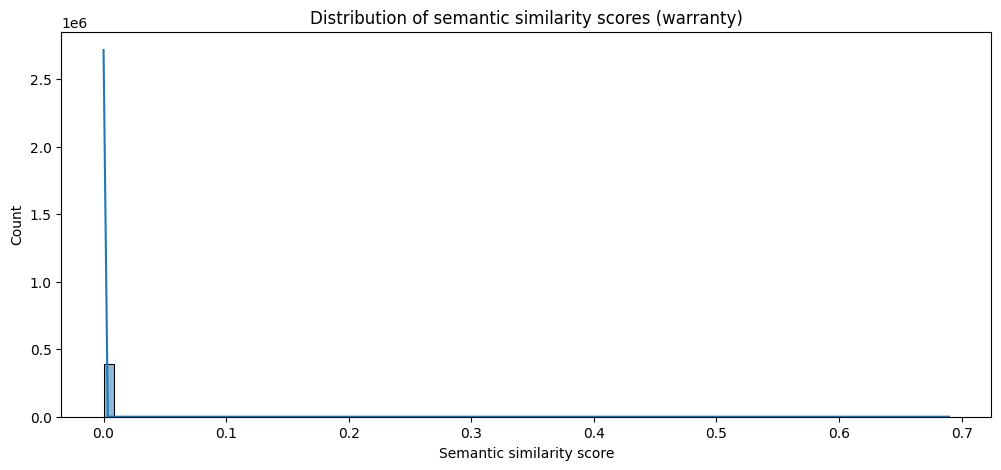

In [32]:
# Distribution of semantic scores
plt.figure(figsize=(12,5))
sns.histplot(train_df['warranty_semantic_score'], bins=80, kde=True)
plt.title('Distribution of semantic similarity scores (warranty)')
plt.xlabel('Semantic similarity score')
plt.show()

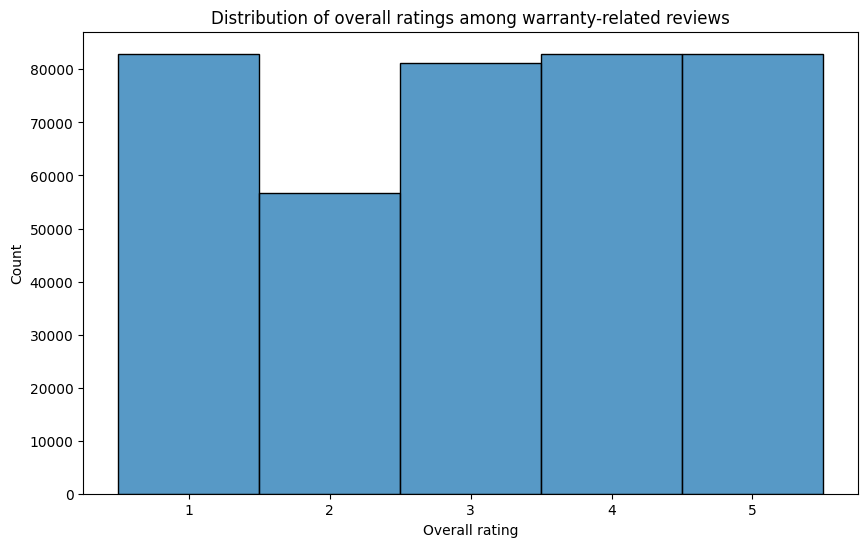

In [33]:
# Distribution of overall ratings
plt.figure(figsize=(10,6))
sns.histplot(warranty_reviews_df['overall'], bins=5, discrete=True)
plt.title('Distribution of overall ratings among warranty-related reviews')
plt.xlabel('Overall rating')
plt.show()

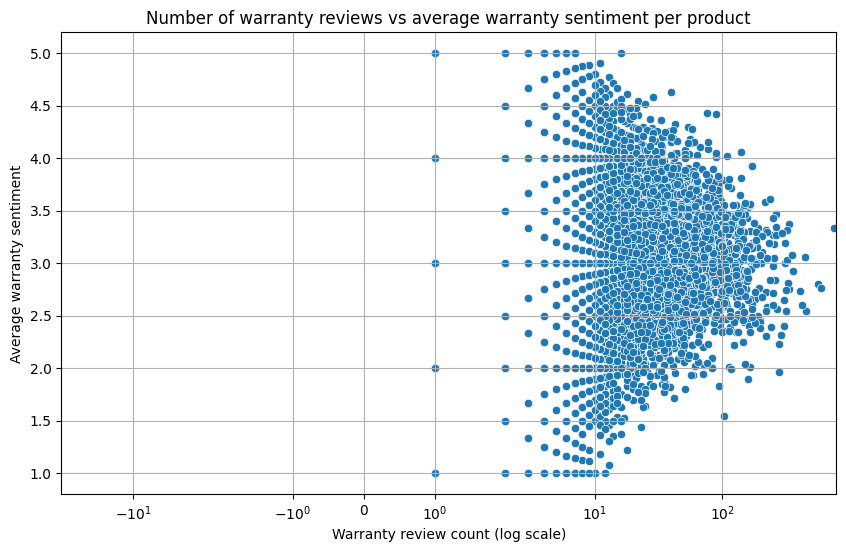

In [34]:
# Scatter: review count vs sentiment
plt.figure(figsize=(10,6))
sns.scatterplot(data=warranty_sentiment_by_product, x='warranty_review_count', y='avg_warranty_sentiment')
plt.xscale('symlog')
plt.title('Number of warranty reviews vs average warranty sentiment per product')
plt.xlabel('Warranty review count (log scale)')
plt.ylabel('Average warranty sentiment')
plt.grid(True)
plt.show()

/tmp/ipython-input-3486814312.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_brands = merged.groupby('brand').apply(lambda g: (g['avg_warranty_sentiment']*g['warranty_review_count']).sum() / g['warranty_review_count'].sum()).sort_values(ascending=False).head(20)


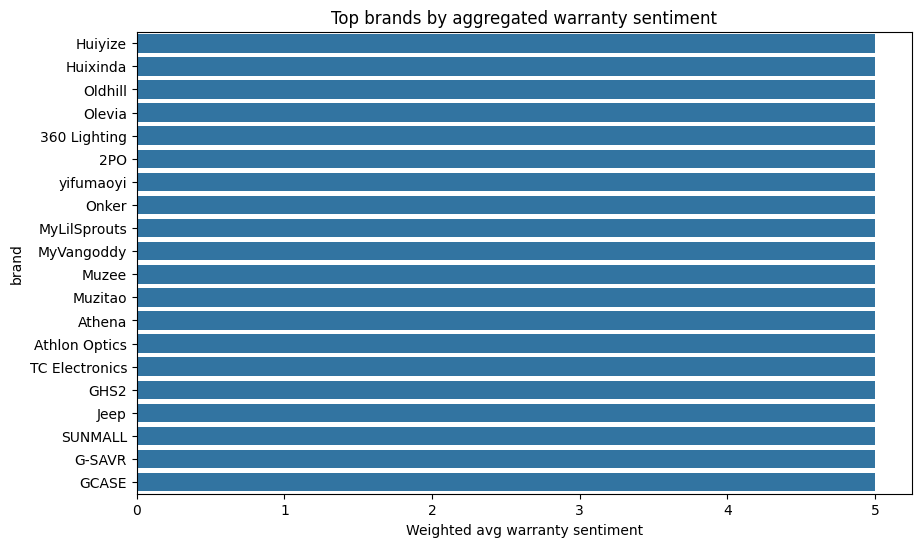

In [35]:
# Top brands by sentiment
if 'brand' in merged.columns:
    top_brands = merged.groupby('brand').apply(lambda g: (g['avg_warranty_sentiment']*g['warranty_review_count']).sum() / g['warranty_review_count'].sum()).sort_values(ascending=False).head(20)
    plt.figure(figsize=(10,6))
    sns.barplot(x=top_brands.values, y=top_brands.index)
    plt.title('Top brands by aggregated warranty sentiment')
    plt.xlabel('Weighted avg warranty sentiment')
    plt.show()

### Example Warranty-Related Reviews

Finally, let's inspect the reviews most and least semantically related to “warranty”.


In [37]:
sorted_reviews = train_df[['fullText','warranty_semantic_score']].sort_values(by='warranty_semantic_score', ascending=False)

print("Top 10 most related to warranty:")
display(sorted_reviews.head(10))

print("Top 10 least related to warranty:")
display(sorted_reviews.tail(10))

Top 10 most related to warranty:


,fullText,warranty_semantic_score
71118,great customer service should not end once the...,0.689735
108535,had a repair done and it was a fast and easy p...,0.676736
381327,great customer service . great customer servic...,0.658046
131615,"bad return policy. product itself okay, but to...",0.654404
11103,a dead on arrival b got this confused with the...,0.654165
371182,i am really really glad i buy these warranties...,0.651214
63300,no returns allowed!!! . one star because the ...,0.640888
122238,pray you never need warranty service! . router...,0.639816
25780,arrived in good condition and looks attractive...,0.626262
15293,no return policy item does not fit the device...,0.622462


Top 10 least related to warranty:


,fullText,warranty_semantic_score
128967,will not work with all switches . i found that...,0.0
128966,not built to last . longevity was 4 months. i ...,0.0
128965,not great. reverts to static regularly. . this...,0.0
128964,not a fan . the rca lines are not built to be ...,0.0
128963,battery life need improvement . i have only ha...,0.0
128962,flat cords have built in holder but dont last ...,0.0
128961,hasnt been dependable . im really disappointed...,0.0
128960,terrible sound quality for music . these have ...,0.0
128959,seems to stop working after a short period . t...,0.0
128970,"nope, just...no. . nope, just...no. where to s...",0.0


In [47]:
print(sorted_reviews.iloc[0,:].fullText)
print(sorted_reviews.iloc[1,:].fullText)
print(sorted_reviews.iloc[2,:].fullText)

great customer service should not end once the product has ... . i got a faulty battery. i contacted customer service for assistance, as in help in troubleshooting at the very least. some employee named carla replied that they could not help because they didnt cover warranty for the first 30 days and to contact amazon. granted that i could still do that, im so turned off by their aftersales service that i probably will just throw this out or file a chargeback with my bank. great customer service should not end once the product has been paid for.
had a repair done and it was a fast and easy process. when i received my computer back it ... . this gets two stars for the following reasons had a repair done and it was a fast and easy process. when i received my computer back it was back to working condition. no complaints there. however, there was damage done and stuff removed from my computer. in places where no repairs were done. in all the paperwork i received back nothing mentioned the 

In [48]:
print(sorted_reviews.iloc[-1,:].fullText)
print(sorted_reviews.iloc[-2,:].fullText)
print(sorted_reviews.iloc[-3,:].fullText)

nope, just...no. . nope, just...no. where to start... lets see  first the audio quality is not good. its muddy and not very clear. i listen to lots of different things from my iphone 8 and these headphones only worked ok with music. podcasts and shows via netflix, etc sounded bassheavy, muddy and sometimes i could barely hear what the people were actually saying. then theres the fit. since these units have a large backing piece just behind the actual earbuds, i couldnt get them far enough into my ear to create a decent seal against my ear canal. and when walking outside with them in, the wind noise around these headphones was unbearable. granted, im sure plenty of folks think theyre ok for the price, but theres a limit to how far im willing to go. i returned these pretty quick and went with a completely different and better product instead. i gave this one two stars and not one because they do actually work as headphones and seem to be passable as a product.
seems to stop working after

### Summary and Insights

- The model effectively detects reviews discussing **warranty, replacement, and repair** using semantic similarity.  
- Products with higher warranty sentiment tend to belong to **established brands** with good after-sales support.  
- Negative warranty-related reviews often mention **poor response time**, **refund issues**, or **defective items**.  
- The approach can be expanded to other service aspects (e.g., shipping, packaging, customer service).

✅ **Output saved:** `/content/warranty_sentiment_by_product.csv`
